# **P**redicting **A**ccurate **S**pectral **T**races for **A**strophysical **SOSS** Spectra Package Demo 
----

This notebook demonstrates how to use the `PASTASOSS` package to rapidly generate the trace positions for NIRISS/SOSS observations, in addition we include and example SOSS observation. `PASTASOSS` uses reference models of trace positions for commanded position of the GR700XD, for order 1 and 2. We apply a rotation transform to reference models to derive the trace positions for any given pupil wheel position angle that is included in the FITS header using the keyword `PWCPOS`. The associate wavelength for each trace positions will be added to the tool at a later date to provide a complete picture with sub-pixel performance. Future iterations of this will include update models for spectral traces positions and will eventually include support for order 3. 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jwst import datamodels
from astroquery.mast import Observations

import pastasoss

## Downloading data from MAST

First, were going download some NIRISS/SOSS data products from MAST using `astroquery` for PID 1512 calibration program (PI: Néstor Espinoza) to demonstrate how to use the PASTASOSS to predict the trace positions. 


1. Query MAST.

In [2]:
# query the data of interest
observation = Observations.query_criteria(instrument_name = 'NIRISS*', proposal_id = '1512', 
                                          target_name = 'BD+60-1753', filters="*GR700XD")
# observation.show_in_notebook(display_length=5)

2. Get the data products.

In [3]:
data_products = Observations.get_product_list(observation)
# data_products.show_in_notebook(display_length=5)

3. Filter the data products to find the observation we want. In this case, we're interest in the `RATEINTS`.

In [4]:
filtered_products = Observations.filter_products(data_products, productType = 'SCIENCE', productSubGroupDescription = 'RATEINTS')
# filtered_products.show_in_notebook(display_length=5)

4. Filter the files with longest integrations (i.e., the files that have the largest file size) and have a the a similar naming pattern to `jw01512001001_03102_00001_nis` - `jw01512001001_03102_00010_nis`

In [5]:
filtered_products = filtered_products[filtered_products['size']== 104915520]
# filtered_products.show_in_notebook(display_length=5)

5. Download the desired data products from our filtered list of observations. This might take some time ~20 sec.

In [6]:
# here you can choose which dataset you want by changing the index.
obs_index = 4

manifest = Observations.download_products(filtered_products[obs_index])
manifest

INFO: Found cached file ./mastDownload/JWST/jw01512005001_03102_00001_nis/jw01512005001_03102_00001_nis_rateints.fits with expected size 104915520. [astroquery.query]


Local Path,Status,Message,URL
str93,str8,object,object
./mastDownload/JWST/jw01512005001_03102_00001_nis/jw01512005001_03102_00001_nis_rateints.fits,COMPLETE,None,None


## Load and check the downloaded data.

For this step, We're going to use the 'JWST.datamodels' module for to load in the data. You may also use astropy as well.  

In [7]:
rateints = datamodels.open(manifest['Local Path'][0])

In [8]:
rateints.data.shape

(10, 256, 2048)

For this demonstration we're going to use a single frame from the loaded dataset, in this instance, the median frame. You may recieve and warning at this step which we can ignore. 

In [9]:
median_rateints = np.nanmedian(rateints.data, axis=0)

/Users/jfilippazzo/opt/miniconda3/envs/jwst-3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [10]:
median_rateints.shape

(256, 2048)

Now we need to extract the pupil wheel position of the GR700XD from the header given by the appropiate keyword. Also, a JWST datamodel object makes it easy to search keywords but using the `search` method. The keyword we are interested in is the `pupil_position`. Alternatively, if the data is loaded using astropy, one can use the `PWCPOS` keyword to extract the value from the header, see below:

```python
from astropy.io import fits
pwcpos = fits.getheader(manifest['Local Path'][0])['PWCPOS']
print(pwcpos)
```

In [11]:
rateints.search('pupil')

root (AsdfObject)
└─meta (dict)
  └─instrument (dict)
    ├─pupil (str): GR700XD
    └─pupil_position (float): 245.8080000000003

In [12]:
pwcpos = rateints.meta.instrument.pupil_position

print(f"The PWCPOS value for {rateints.meta.filename} is {pwcpos:3f} degrees")

The PWCPOS value for jw01512005001_03102_00001_nis_rateints.fits is 245.808000 degrees


Now let's plot the SOSS Observation data.

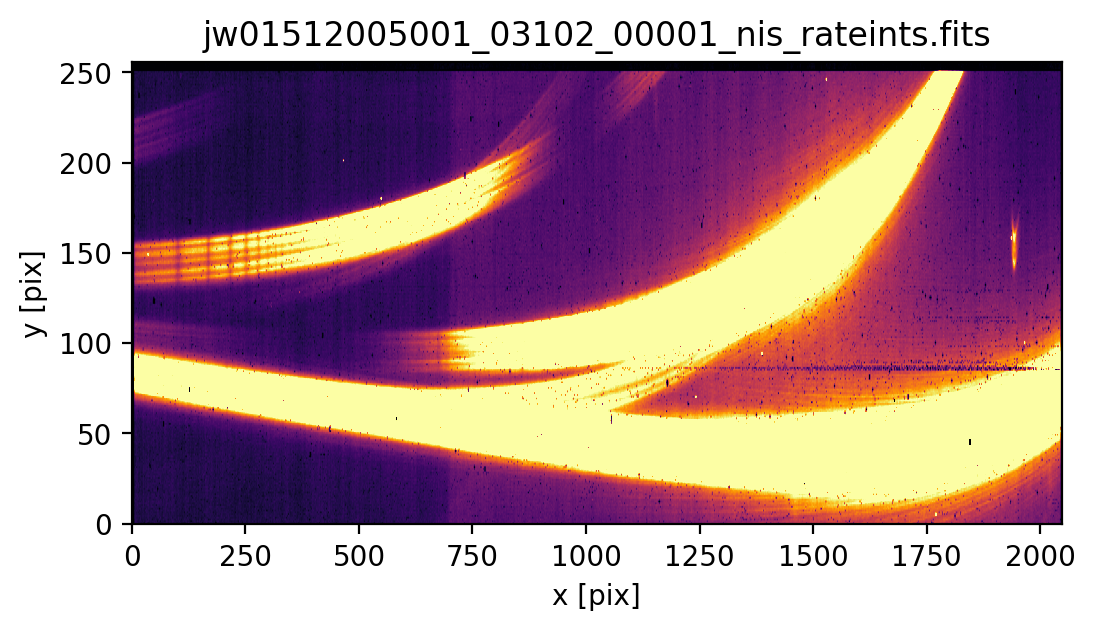

In [13]:
# Plot the image
plt.figure(figsize=(6,3), dpi=200)
plt.title(f'{rateints.meta.filename}')
plt.imshow(np.nan_to_num(median_rateints), vmin=0, vmax=20, origin='lower', aspect='auto',cmap='inferno')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')
plt.show()

The example observation show the three dispersed spectral orders along with some cross-contamination overlap of dispersed spectral orders from nearby field star. An order 0 of the nearby field star is present in the top right. The 1/f noise is given by the striped-banding across the image columns in addition to the dispersed zodiacal background given by the sudden jump in counts near pixel column 700. 

It is a known issue that have a large number of `DO_NOT_USE` pixels with the current JWST calibration pipeline and are working to resolve this issues. These pixels were mark as `nans`. We can ignore these for the demo.

## Generate Trace Positions for a NIRISS/SOSS observation using PASTASOSS

We will demonstratte how to use `PASTASOSS` to generate the spectral traces a NIRISS/SOSS observation where we only require the pupil wheel position or `PWCPOS` value which we have already extracted from the file header/datamodel.


<!-- First's, load in an example image that has been provided for this notebook and the pupil wheel position associated with the SOSS observation has been given. We will demonstratte how to use `PASTASOSS` to generate the trace positions for this observation given the pupil wheel position.

The example SOSS observation used in this demo is from the calibration program 1512 dataset. 

Let's begin by loading in the image for this demo: -->

To do this we will use the `get_soss_traces` function from `PASTASOSS`.

In [14]:
# get the order 1 traces for the desired PWCPOS 
traces_order1 = pastasoss.get_soss_traces(pwcpos=pwcpos, order='1', interp=True) 

# now for order 2
traces_order2 = pastasoss.get_soss_traces(pwcpos=pwcpos, order='2', interp=True)

The `get_soss_traces` method will use the included trace and wavelength calibration model to predict the trace (x, y) pixel positions and their associated wavelength values in units of microns. This method will return a TraceModel that is a dataclass object to store the trace properties (i.e., order, x, y, wavelength). 

In [15]:
type(traces_order1)

pastasoss.soss_traces.TraceModel

In [16]:
print(traces_order1)

TraceModel(order='1', x=array([   4.,    5.,    6., ..., 2041., 2042., 2043.]), y=array([83.099029  , 83.05656555, 83.0141021 , ..., 74.89775841,
       75.0819369 , 75.2661154 ]), wavelength=array([2.82857137, 2.8275845 , 2.82659758, ..., 0.85211363, 0.85123528,
       0.85035722]))


You can also called the function in a single line by the follow:

In [17]:
# uncomment this line and run the cell
# traces_order1, traces_order2 = pastasoss.get_soss_traces(pwcpos=pwcpos, order='12', interp=True)

Next, lets plot our traces we just generated for this observation ontop of our image. Let separate our traces into their x-,y-compenents.

In [18]:
x1, y1, wave1 = traces_order1.x, traces_order1.y, traces_order1.wavelength
x2, y2, wave2 = traces_order2.x, traces_order2.y, traces_order2.wavelength

Now lets plots traces for orders 1 and 2 on top of our example SOSS observations.

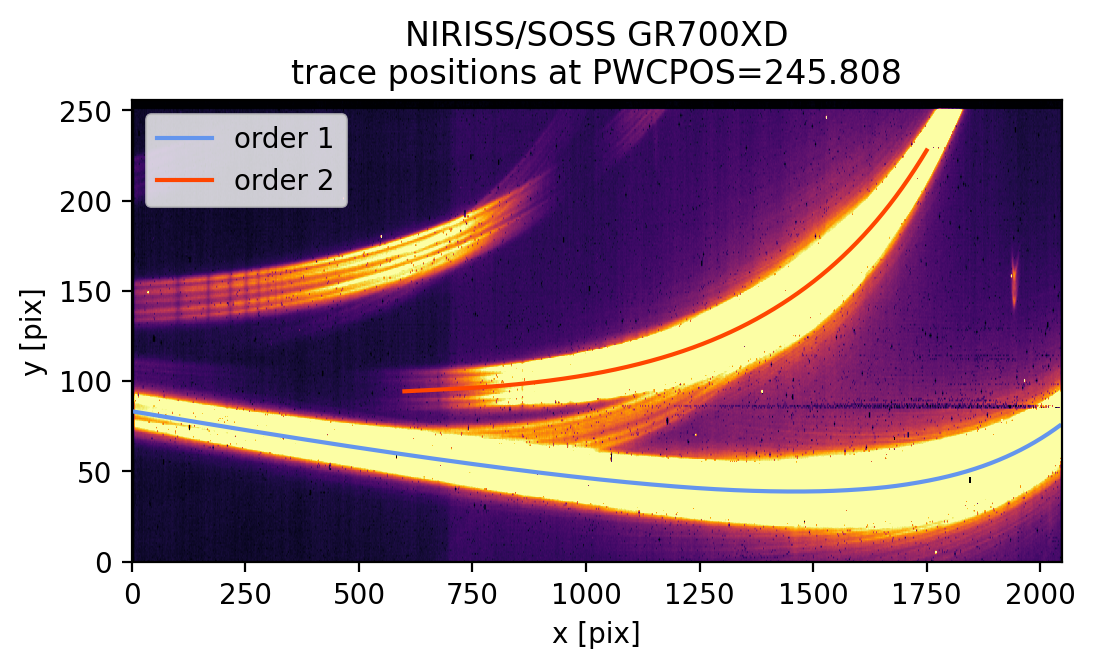

In [19]:
plt.figure(figsize=(6,3), dpi=200)
plt.title(f'NIRISS/SOSS GR700XD\ntrace positions at PWCPOS={pwcpos:.3f}')
plt.imshow(np.nan_to_num(median_rateints), vmin=0, vmax=30, origin='lower', aspect='auto', cmap='inferno')
plt.plot(x1,y1, lw=1.5, label=f'order 1', color='cornflowerblue')
plt.plot(x2,y2, lw=1.5, label=f'order 2', color='orangered')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')
plt.legend()
plt.show()

As you can see, we are able to predict the traces positions for orders 1 and 2 very well with sub-pixel performance. Order 1 has full coverage across the detector while order 2 extends from pixel column 1000 to 1750. This was due to the limit data at the time of producing the trace model and will be updated in the future to span 650 to 1750 and eventually span all of order 2. Order 3 will be supported in the future. 

# Spectral Extraction

Now that we have our traces positions for spectral order 1 and 2, we can perform a simple aperutre extraction to extract the spectrum.  

In [20]:
data = np.nan_to_num(median_rateints.copy())

# ignore values less zero
data[data<0] = 0

# Define how many pixels we want to set our aperture above and below the trace center
npix = 15

# perform a simple aperture extraction via cutout of a desired window size. 
flux_order1 = [data[int(y)-npix:int(y)+npix, int(x)].sum() for x, y in zip(x1, y1)]
flux_order2 = [data[int(y)-npix:int(y)+npix, int(x)].sum() for x, y in zip(x2, y2)]

Let's plot the extracted spectrum for orders 1 and 2.

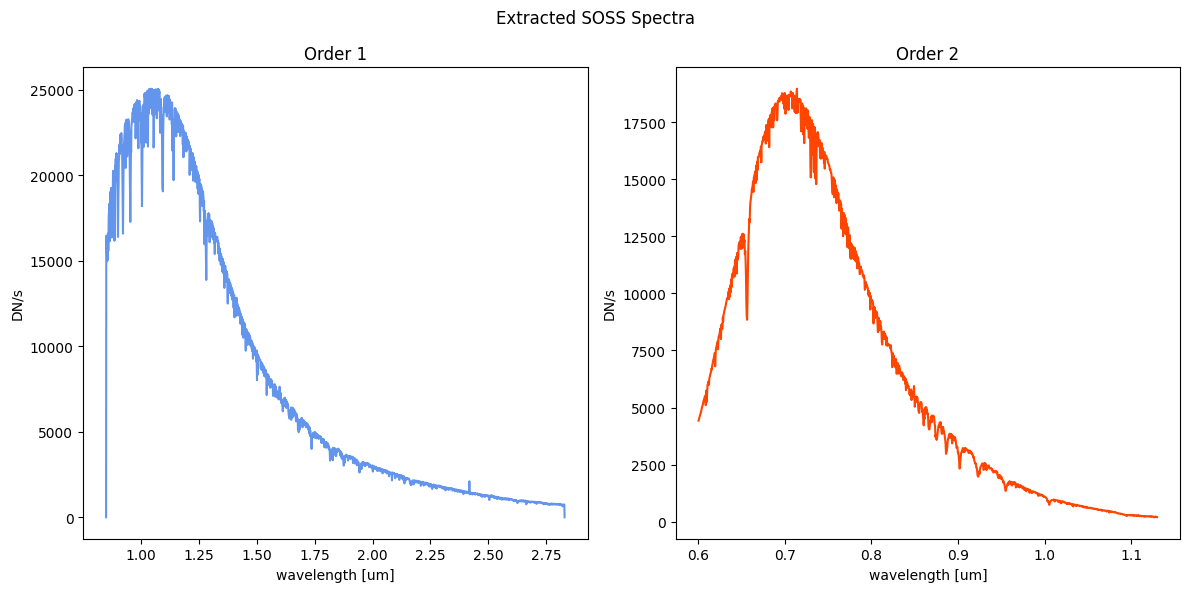

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Extracted SOSS Spectra')
ax1.set_title('Order 1')
ax1.plot(wave1, flux_order1, lw=1.5, label=f'order 1', color='cornflowerblue')
ax1.set_xlabel('wavelength [um]')
ax1.set_ylabel('DN/s')


ax2.set_title('Order 2')
ax2.plot(wave2, flux_order2, lw=1.5, label=f'order 2', color='orangered')
ax2.set_xlabel('wavelength [um]')
ax2.set_ylabel('DN/s')

plt.tight_layout()
plt.show()

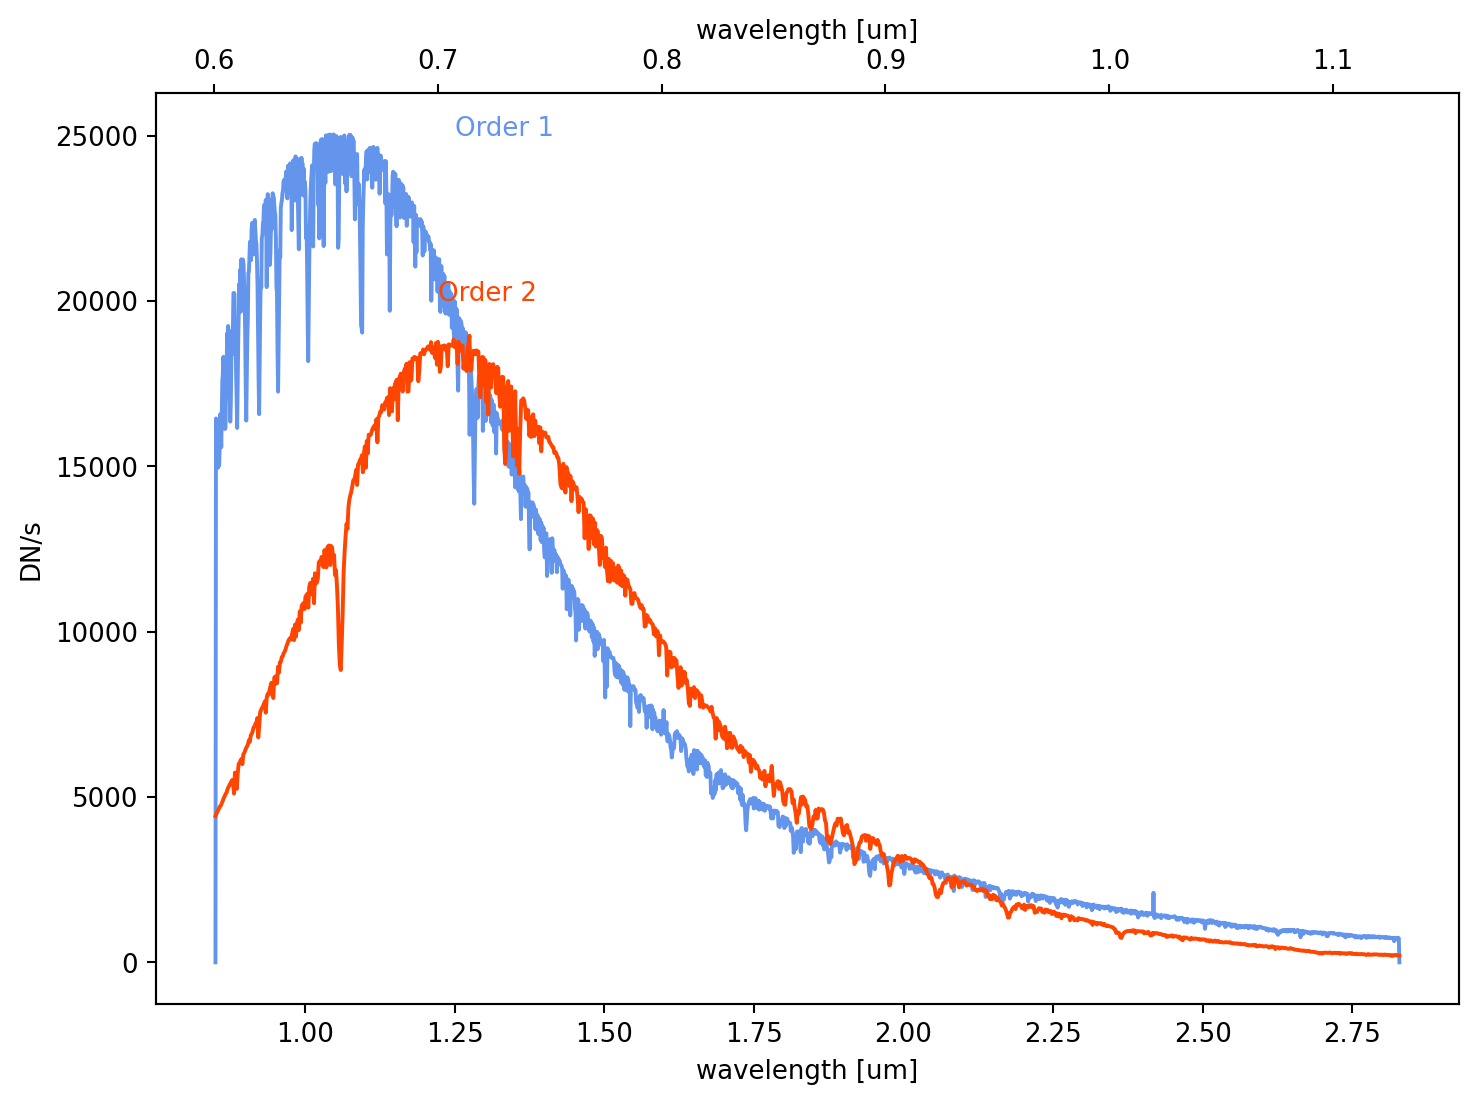

In [22]:
plt.figure(figsize=(8,6), dpi=187)
plt.plot(wave1, flux_order1, lw=1.5, label=f'order 1', color='cornflowerblue')
plt.xlabel('wavelength [um]')
plt.ylabel('DN/s')
plt.text(1.25, 25000, 'Order 1', color='cornflowerblue')
plt.twiny()
plt.plot(wave2, flux_order2, lw=1.5, label=f'order 2', color='orangered')
plt.text(0.7, 20000, 'Order 2', color='orangered')
plt.ylabel('DN/s (order 2)')
plt.xlabel('wavelength [um]')
# plt.legend()

plt.tight_layout()
plt.show()

# Conclusion

This concludes the demo (v1.1) of how to use the PASATSOSS Package.

Our goal with PASTASOSS to provide the community with a tool to predict the spectral traces (i.e, their positions on the detector and associated wavelengths for the three GR700XD diffraction orders) given a PWCPOS value. 

### Future priority updates to include into the PASTASOSS package:
1. Support for order 3 traces and wavelength calibration
2. Update trace and wavelength calibration models when more data becomes available
3. Possible integration into the JWST calibration pipeline (TBD). 


### Additional features that may be included in the future:
1. integrated method(s) to trace spectral such as:
    - the applesoss edge-triger algorithm 
    - transitspectroscopy cross-correlation algorithm
2. spatial profiles
3. Background model prediction for Background Subtraction (integrated or standalone)
4. 1/f noise removal


-----

If you use this tool in your work, please cite the tool and author(s). For questions about the tool or interested in contributing to the package in any way, please contact the authors. 

Links to Technical Reports (TBD):
1. Visit-to-visit Trace Characterization (Jdox | arXiv)
2. Visit-to-visit Wavelength Solution (Jdox | arXiv)

##  About this notebook
>**_version_**: 1.1.0
>
>**_Author_**: Tyler Baines, STScI Science Support Analyst
>
>**_Email_**: <tbaines@stsci.edu>
>
>**_Date Updated_**: 9/08/2023
>
>**_Observatory_**: JWST
>
>**_Instrument/Mode_**: NIRISS/SOSS

____